<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_ayam_ras_segar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f5d011159d0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_ayam_ras_segar.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


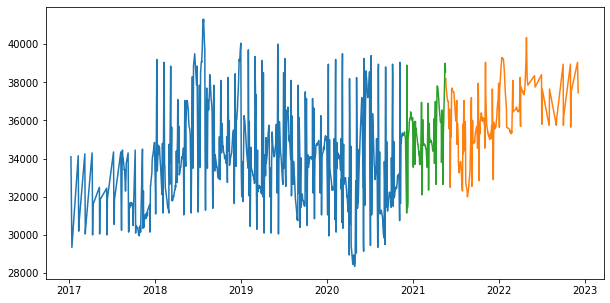

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [10]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

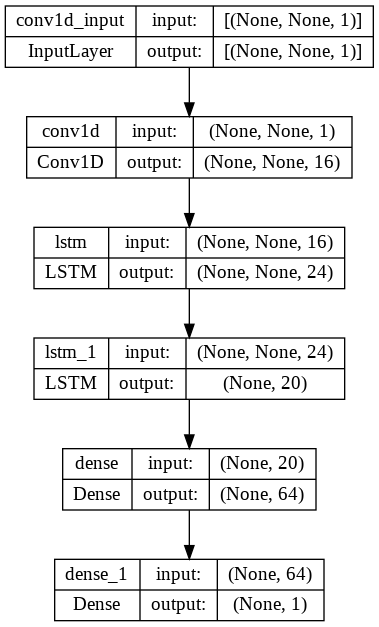

In [11]:
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [12]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 46ms/step - loss: 0.1532 - mae: 0.3351 - mape: 18546.1855 - val_loss: 0.3130 - val_mae: 0.5240 - val_mape: 82.1647
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1080 - mae: 0.2694 - mape: 347478.3125 - val_loss: 0.2423 - val_mae: 0.4515 - val_mape: 68.6028
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0798 - mae: 0.2241 - mape: 694886.7500 - val_loss: 0.1940 - val_mae: 0.3979 - val_mape: 59.7887
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0635 - mae: 0.1930 - mape: 921584.5625 - val_loss: 0.1627 - val_mae: 0.3606 - val_mape: 54.3205
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0541 - mae: 0.1761 - mape: 1075762.6250 - val_loss: 0.1415 - val_mae: 0.3325 - val_mape: 50.2045
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0488 - mae: 0.1655 - mape: 1211991.8750 - val_loss: 0.1256 - val_mae:

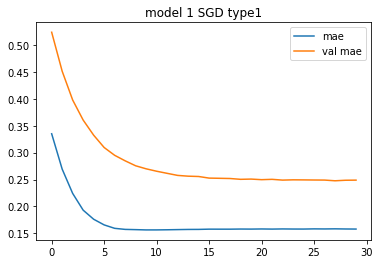

In [13]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_ayam_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 8ms/step
2589.4739 7.036531 2938.538922662077


,date,actual,prediction
0,2021-05-20,38200,33313.125000
1,2021-05-21,37850,33368.601562
2,2021-05-24,37400,33356.632812
3,2021-05-25,37300,33419.535156
4,2021-05-27,37150,33411.085938
...,...,...,...
229,2022-11-02,35650,33716.406250
230,2022-11-03,36250,33716.093750
231,2022-11-04,37500,33712.644531
232,2022-12-01,39050,33707.628906


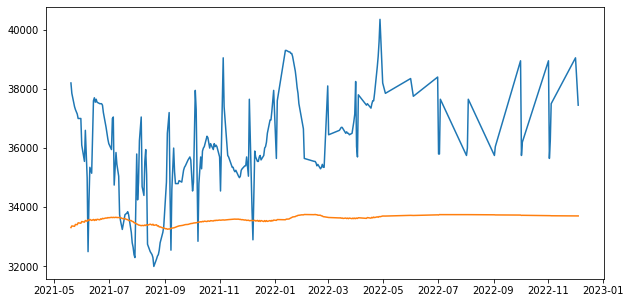

In [15]:
prediction = forecast_predict(model, test_ayam_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_ayam = pd.DataFrame()
data_new_ayam['date'] = y_test
data_new_ayam['actual'] = x_test
data_new_ayam['prediction'] = data_result
data_new_ayam.to_csv('dagingayam_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_ayam.date, data_new_ayam.actual)
plt.plot(data_new_ayam.date, data_new_ayam.prediction)
data_new_ayam

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0329 - mae: 0.1414 - mape: 517431.2500 - val_loss: 0.0757 - val_mae: 0.2284 - val_mape: 36.5082
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0321 - mae: 0.1391 - mape: 553965.8750 - val_loss: 0.0773 - val_mae: 0.2316 - val_mape: 36.9063
Epoch 3/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0325 - mae: 0.1400 - mape: 510160.4375 - val_loss: 0.0749 - val_mae: 0.2268 - val_mape: 36.3178
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0320 - mae: 0.1394 - mape: 544438.3125 - val_loss: 0.0768 - val_mae: 0.2305 - val_mape: 36.7740
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0322 - mae: 0.1399 - mape: 543627.3125 - val_loss: 0.0766 - val_mae: 0.2301 - val_mape: 36.7172
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0320 - mae: 0.1395 - mape: 540388.2500 - val_loss: 0.0786 - val_

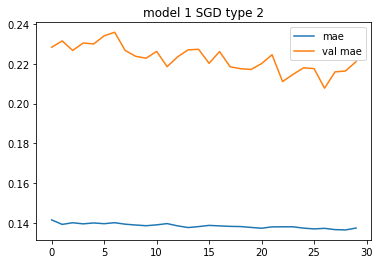

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2105.418 5.7269135 2428.8745336060488


,date,actual,prediction
0,2021-05-20,38200,33313.125000
1,2021-05-21,37850,33368.601562
2,2021-05-24,37400,33356.632812
3,2021-05-25,37300,33419.535156
4,2021-05-27,37150,33411.085938
...,...,...,...
229,2022-11-02,35650,33716.406250
230,2022-11-03,36250,33716.093750
231,2022-11-04,37500,33712.644531
232,2022-12-01,39050,33707.628906


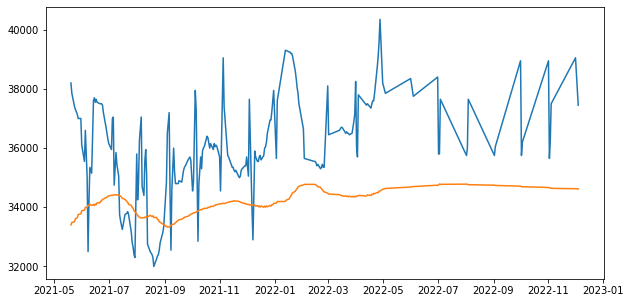

In [18]:
win_size1 = 60
test_ayam_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_ayam_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_ayam_1 = pd.DataFrame()
data_new_ayam_1['actual'] = x_test
data_new_ayam_1['prediction'] = data_result_1
data_new_ayam_1.to_csv('dagingayam_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_ayam_1.actual)
plt.plot(y_test, data_new_ayam_1.prediction)
data_new_ayam

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0303 - mae: 0.1334 - mape: 799259.6875 - val_loss: 0.0672 - val_mae: 0.2111 - val_mape: 34.5608
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0302 - mae: 0.1332 - mape: 797499.9375 - val_loss: 0.0669 - val_mae: 0.2106 - val_mape: 34.5082
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0302 - mae: 0.1333 - mape: 805483.6875 - val_loss: 0.0673 - val_mae: 0.2114 - val_mape: 34.5901
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0302 - mae: 0.1333 - mape: 795565.0000 - val_loss: 0.0665 - val_mae: 0.2099 - val_mape: 34.4395
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0302 - mae: 0.1332 - mape: 798807.0625 - val_loss: 0.0662 - val_mae: 0.2093 - val_mape: 34.3750
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0302 - mae: 0.1333 - mape: 795541.8750 - val_loss: 0.0663 - val_mae: 0

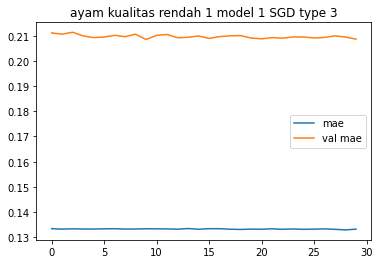

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('ayam kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1937.5298 5.274268 2259.552168019141


,actual,prediction
0,38200,33635.613281
1,37850,33721.851562
2,37400,33744.628906
3,37300,33853.726562
4,37150,33881.460938
...,...,...
229,35650,34877.570312
230,36250,34877.167969
231,37500,34857.562500
232,39050,34846.574219


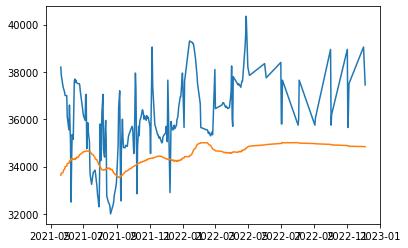

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_ayam_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_ayam_2 = pd.DataFrame()
# data_new_ayam1['date'] = date_test
data_new_ayam_2['actual'] = x_test
data_new_ayam_2['prediction'] = data_result_2
data_new_ayam_2.to_csv('dagingayam_model1_sgd_type3.csv')

plt.plot(y_test, data_new_ayam_2.actual)
plt.plot(y_test, data_new_ayam_2.prediction)
data_new_ayam_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 39ms/step - loss: 0.1195 - mae: 0.2851 - mape: 489124.2812 - val_loss: 0.1869 - val_mae: 0.3900 - val_mape: 58.7168
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0538 - mae: 0.1757 - mape: 618632.8125 - val_loss: 0.0700 - val_mae: 0.2175 - val_mape: 35.3722
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0433 - mae: 0.1635 - mape: 1294101.3750 - val_loss: 0.0629 - val_mae: 0.2030 - val_mape: 33.7861
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0427 - mae: 0.1581 - mape: 1276849.5000 - val_loss: 0.0646 - val_mae: 0.2062 - val_mape: 34.0866
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0427 - mae: 0.1617 - mape: 1368039.5000 - val_loss: 0.0634 - val_mae: 0.2038 - val_mape: 33.8310
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0423 - mae: 0.1598 - mape: 1349138.0000 - val_loss: 0.0636 - val_ma

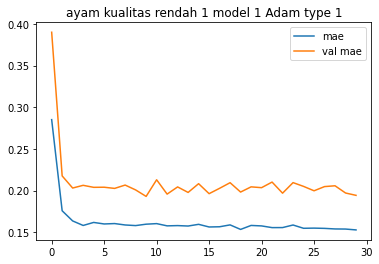

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('ayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1763.1056 4.7988167 2086.7415987610925


,actual,prediction
0,38200,33856.597656
1,37850,33934.628906
2,37400,34088.140625
3,37300,34220.554688
4,37150,34349.449219
...,...,...
229,35650,34969.777344
230,36250,34996.242188
231,37500,34933.031250
232,39050,34917.382812


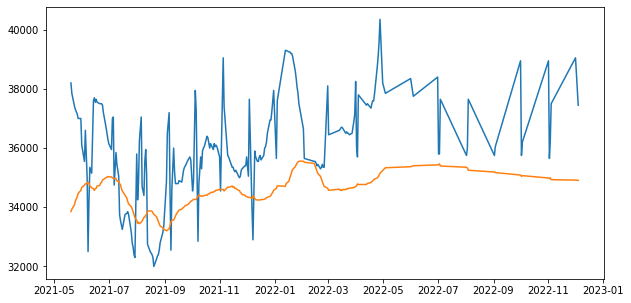

In [25]:
prediction_a = forecast_predict(model_a, test_ayam_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_ayam_a = pd.DataFrame()
# data_new_ayam1['date'] = date_test
data_new_ayam_a['actual'] = x_test
data_new_ayam_a['prediction'] = data_result_a
data_new_ayam_a.to_csv('dagingayam_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_ayam_a.actual)
plt.plot(y_test, data_new_ayam_a.prediction)
data_new_ayam_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0297 - mae: 0.1329 - mape: 352197.7500 - val_loss: 0.0512 - val_mae: 0.1757 - val_mape: 31.2362
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0292 - mae: 0.1326 - mape: 403292.2188 - val_loss: 0.0612 - val_mae: 0.1951 - val_mape: 32.5694
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0293 - mae: 0.1319 - mape: 323297.6562 - val_loss: 0.0517 - val_mae: 0.1749 - val_mape: 30.9772
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0290 - mae: 0.1304 - mape: 332240.8750 - val_loss: 0.0548 - val_mae: 0.1796 - val_mape: 31.0457
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0290 - mae: 0.1316 - mape: 337204.4375 - val_loss: 0.0555 - val_mae: 0.1811 - val_mape: 31.1395
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0292 - mae: 0.1315 - mape: 383263.0625 - val_loss: 0.0547 - val_

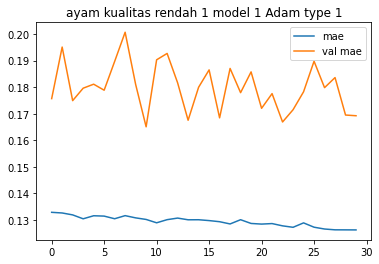

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('ayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1495.286 4.071663 1824.5161002304146


,actual,prediction
0,38200,34139.769531
1,37850,34171.867188
2,37400,34625.992188
3,37300,34754.218750
4,37150,35019.886719
...,...,...
229,35650,35518.996094
230,36250,35697.371094
231,37500,35431.234375
232,39050,35450.250000


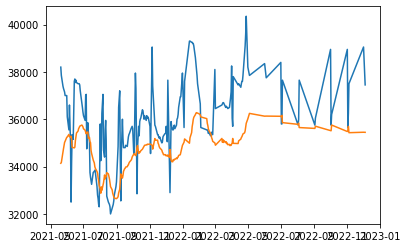

In [28]:
prediction_a1 = forecast_predict(model_a, test_ayam_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_ayam_a1 = pd.DataFrame()
data_new_ayam_a1['actual'] = x_test
data_new_ayam_a1['prediction'] = data_result_a1
data_new_ayam_a1.to_csv('dagingayam_model1_adam_type2.csv')

plt.plot(y_test, data_new_ayam_a1.actual)
plt.plot(y_test, data_new_ayam_a1.prediction)
data_new_ayam_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0273 - mae: 0.1217 - mape: 542849.5000 - val_loss: 0.0502 - val_mae: 0.1699 - val_mape: 29.9695
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0274 - mae: 0.1223 - mape: 545984.7500 - val_loss: 0.0527 - val_mae: 0.1760 - val_mape: 30.5052
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0273 - mae: 0.1218 - mape: 539468.8750 - val_loss: 0.0525 - val_mae: 0.1751 - val_mape: 30.4088
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0272 - mae: 0.1209 - mape: 517308.3750 - val_loss: 0.0489 - val_mae: 0.1664 - val_mape: 29.6778
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0272 - mae: 0.1212 - mape: 520636.7500 - val_loss: 0.0489 - val_mae: 0.1663 - val_mape: 29.6647
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0272 - mae: 0.1219 - mape: 527666.3125 - val_loss: 0.0512 - val_mae: 0

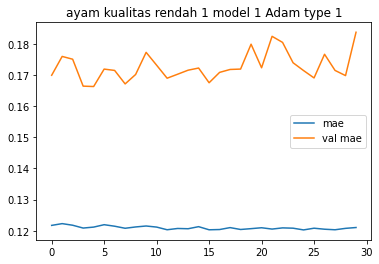

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('ayam kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1640.6869 4.457293 1989.004964800239


,actual,prediction
0,38200,34214.765625
1,37850,34229.632812
2,37400,34635.058594
3,37300,34763.027344
4,37150,34974.554688
...,...,...
229,35650,35121.617188
230,36250,35294.550781
231,37500,35050.937500
232,39050,35051.398438


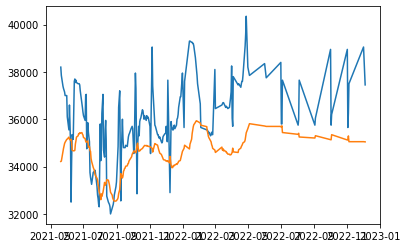

In [31]:
prediction_a2 = forecast_predict(model_a, test_ayam_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_ayam_a2 = pd.DataFrame()
# data_new_ayam1['date'] = date_test
data_new_ayam_a2['actual'] = x_test
data_new_ayam_a2['prediction'] = data_result_a2
data_new_ayam_a2.to_csv('dagingayam_model1_adam_type3.csv')

plt.plot(y_test, data_new_ayam_a2.actual)
plt.plot(y_test, data_new_ayam_a2.prediction)
data_new_ayam_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 42ms/step - loss: 0.0559 - mae: 0.1840 - mape: 1493962.1250 - val_loss: 0.1047 - val_mae: 0.2785 - val_mape: 42.8320
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0428 - mae: 0.1627 - mape: 1601830.8750 - val_loss: 0.0910 - val_mae: 0.2558 - val_mape: 39.9378
Epoch 3/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0456 - mae: 0.1701 - mape: 1239108.0000 - val_loss: 0.0561 - val_mae: 0.1896 - val_mape: 32.8089
Epoch 4/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0409 - mae: 0.1575 - mape: 1534906.2500 - val_loss: 0.0524 - val_mae: 0.1810 - val_mape: 32.2681
Epoch 5/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0406 - mae: 0.1603 - mape: 1194371.5000 - val_loss: 0.1241 - val_mae: 0.3059 - val_mape: 46.2859
Epoch 6/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0410 - mae: 0.1598 - mape: 1077099.3750 - val_loss: 0.0665 

17/17 [==============================] - 0s 8ms/step - loss: 0.0681 - mae: 0.2144 - mape: 30.7254


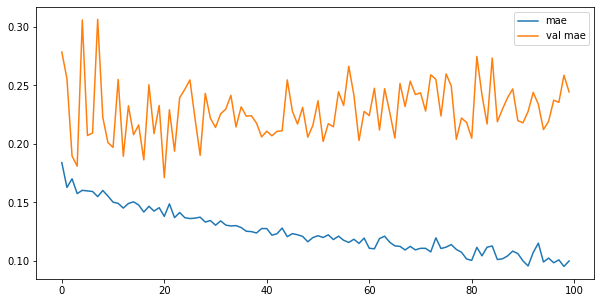

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_ayam_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_ayam1 = pd.DataFrame()
data_new_ayam1['actual'] = x_test
data_new_ayam1['prediction'] = data_result1
data_new_ayam1.to_csv('dagingayam_model2_adam_type1.csv')

data_new_ayam1

131/131 [==============================] - 2s 8ms/step
2641.5977 7.185744 2996.02520016104


,actual,prediction
0,38200,34159.234375
1,37850,34066.050781
2,37400,34045.644531
3,37300,33857.246094
4,37150,34005.734375
...,...,...
229,35650,33616.277344
230,36250,33209.882812
231,37500,33526.050781
232,39050,33576.066406


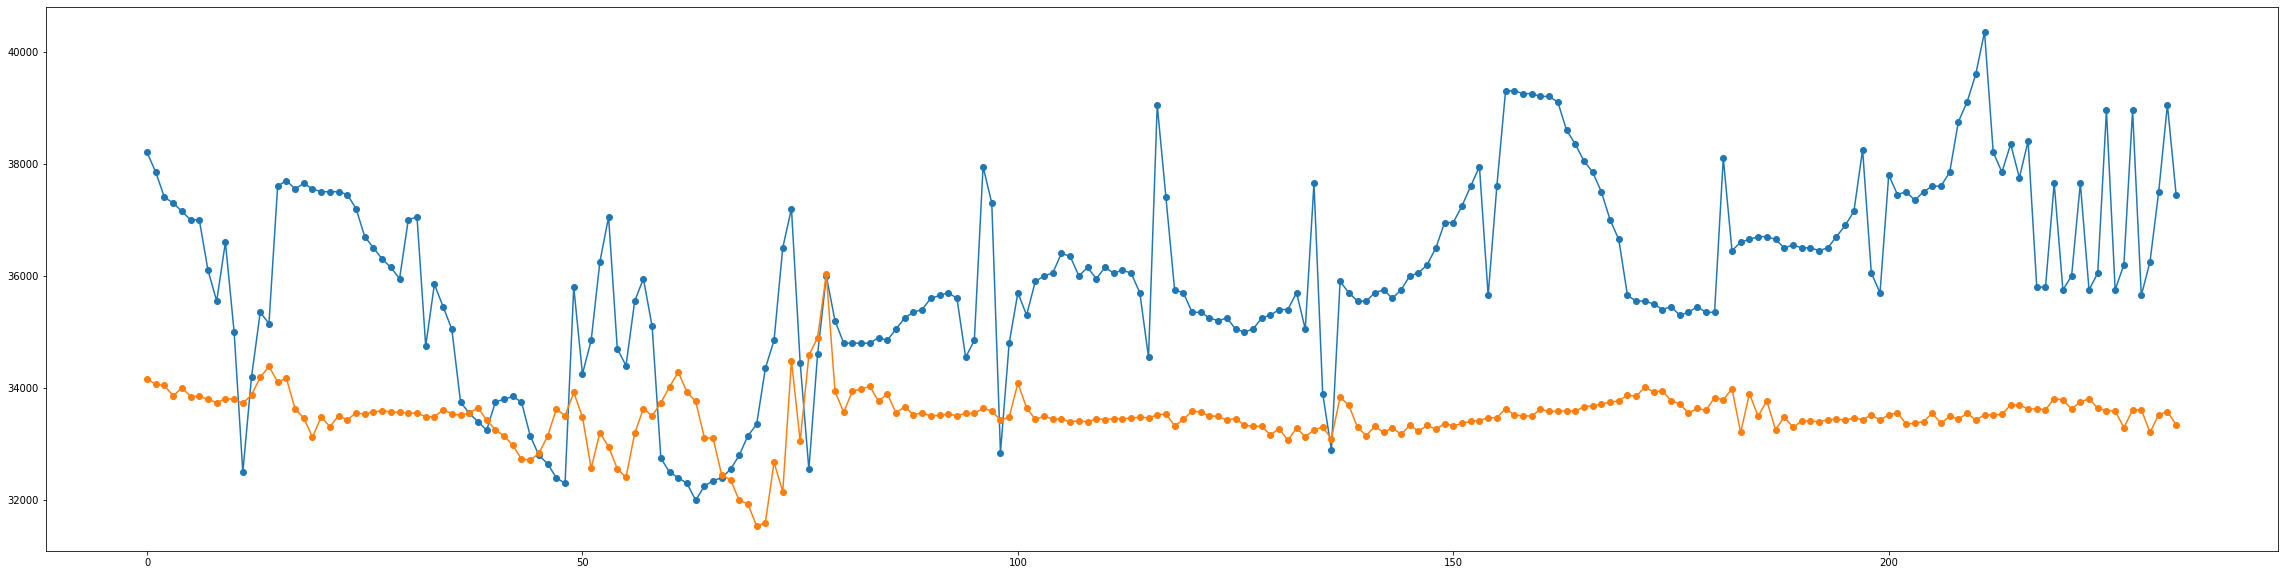

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_ayam1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_ayam1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0308 - mae: 0.1342 - mape: 152951.5938 - val_loss: 0.0448 - val_mae: 0.1648 - val_mape: 31.2500
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0263 - mae: 0.1245 - mape: 43172.0312 - val_loss: 0.0492 - val_mae: 0.1762 - val_mape: 31.4303
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0269 - mae: 0.1236 - mape: 131985.5000 - val_loss: 0.0734 - val_mae: 0.2248 - val_mape: 36.1755
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0256 - mae: 0.1208 - mape: 68604.0781 - val_loss: 0.0630 - val_mae: 0.2029 - val_mape: 33.2051
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0259 - mae: 0.1201 - mape: 160098.7969 - val_loss: 0.0640 - val_mae: 0.2041 - val_mape: 33.7465
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0236 - mae: 0.1153 - mape: 208046.6562 - val_loss: 0.0620 - val_ma

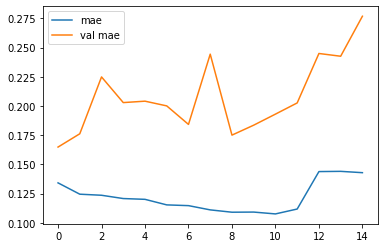

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
3009.9233 8.183062 2996.02520016104


,actual,prediction
0,38200,33032.285156
1,37850,33033.562500
2,37400,33044.140625
3,37300,33054.746094
4,37150,33059.363281
...,...,...
229,35650,33072.191406
230,36250,33106.769531
231,37500,33090.054688
232,39050,33075.605469


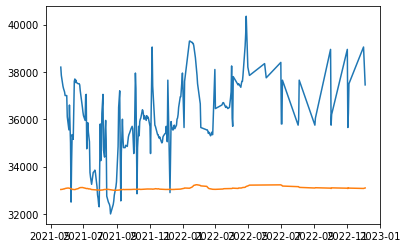

In [39]:
prediction1_1 = forecast_predict(model1, test_ayam_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_ayam1_1 = pd.DataFrame()
data_new_ayam1_1['actual'] = x_test
data_new_ayam1_1['prediction'] = data_result1_1
data_new_ayam1_1.to_csv('dagingayam_model2_adam_type2.csv')

plt.plot(y_test, data_new_ayam1_1.actual)
plt.plot(y_test, data_new_ayam1_1.prediction)
data_new_ayam1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0321 - mae: 0.1381 - mape: 914900.1875 - val_loss: 0.0797 - val_mae: 0.2362 - val_mape: 37.4125
Epoch 2/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0314 - mae: 0.1370 - mape: 924847.0000 - val_loss: 0.0735 - val_mae: 0.2243 - val_mape: 35.8976
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0311 - mae: 0.1363 - mape: 962641.8125 - val_loss: 0.0687 - val_mae: 0.2138 - val_mape: 34.4382
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0305 - mae: 0.1342 - mape: 881899.6875 - val_loss: 0.0568 - val_mae: 0.1905 - val_mape: 32.0362
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0300 - mae: 0.1315 - mape: 873264.8125 - val_loss: 0.0658 - val_mae: 0.2058 - val_mape: 33.3356
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0296 - mae: 0.1301 - mape: 839517.6250 - val_loss: 0.0556 - val_mae: 0

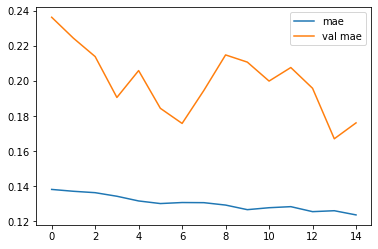

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1600.8949 4.3582907 2996.02520016104


,actual,prediction
0,38200,34784.437500
1,37850,34824.195312
2,37400,35272.960938
3,37300,35622.535156
4,37150,35908.710938
...,...,...
229,35650,34909.042969
230,36250,35078.585938
231,37500,34886.417969
232,39050,34965.914062


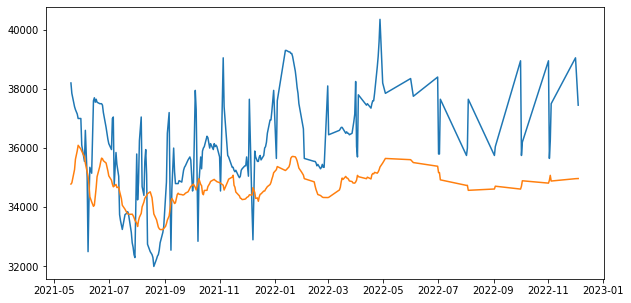

In [42]:
prediction1_2 = forecast_predict(model1, test_ayam_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_ayam1_2 = pd.DataFrame()
data_new_ayam1_2['actual'] = x_test
data_new_ayam1_2['prediction'] = data_result1_2
data_new_ayam1_2.to_csv('dagingayam_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_ayam1_2.actual)
plt.plot(y_test, data_new_ayam1_2.prediction)

data_new_ayam1_2

### SGD

In [43]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1744 - mae: 0.3639 - mape: 66146.6094 - val_loss: 0.3779 - val_mae: 0.5825 - val_mape: 93.0855
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1513 - mae: 0.3326 - mape: 173853.8281 - val_loss: 0.3424 - val_mae: 0.5512 - val_mape: 87.2386
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1333 - mae: 0.3081 - mape: 291854.5625 - val_loss: 0.3134 - val_mae: 0.5243 - val_mape: 82.1929
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1189 - mae: 0.2871 - mape: 452053.1875 - val_loss: 0.2883 - val_mae: 0.4997 - val_mape: 77.6057
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1068 - mae: 0.2692 - mape: 520302.1875 - val_loss: 0.2670 - val_mae: 0.4780 - val_mape: 73.5285
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0967 - mae: 0.2533 - mape: 600195.1250 - val_loss: 0.2477 - val_mae: 0.

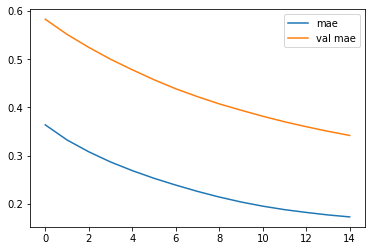

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 8ms/step
1600.7666 4.3579235 1913.2314287612985


,actual,prediction
0,38200,34787.238281
1,37850,34827.113281
2,37400,35275.757812
3,37300,35623.203125
4,37150,35904.386719
...,...,...
229,35650,34908.781250
230,36250,35078.375000
231,37500,34886.316406
232,39050,34965.710938


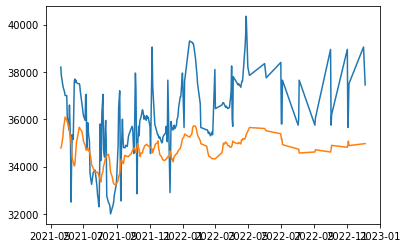

In [47]:
prediction1_a = forecast_predict(model1, test_ayam_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_ayam1_a = pd.DataFrame()
data_new_ayam1_a['actual'] = x_test
data_new_ayam1_a['prediction'] = data_result1_a
data_new_ayam1_a.to_csv('dagingayam_model2_sgd_type1.csv')

plt.plot(y_test, data_new_ayam1_a.actual)
plt.plot(y_test, data_new_ayam1_a.prediction)

data_new_ayam1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0426 - mae: 0.1557 - mape: 545681.3125 - val_loss: 0.0843 - val_mae: 0.2449 - val_mape: 38.5697
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0344 - mae: 0.1418 - mape: 577774.1875 - val_loss: 0.0755 - val_mae: 0.2284 - val_mape: 36.5636
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0338 - mae: 0.1419 - mape: 595342.0625 - val_loss: 0.0747 - val_mae: 0.2269 - val_mape: 36.3985
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0335 - mae: 0.1414 - mape: 586381.3125 - val_loss: 0.0759 - val_mae: 0.2289 - val_mape: 36.6131
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0337 - mae: 0.1411 - mape: 597075.2500 - val_loss: 0.0746 - val_mae: 0.2265 - val_mape: 36.3519
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0335 - mae: 0.1414 - mape: 605696.2500 - val_loss: 0.0744 - val

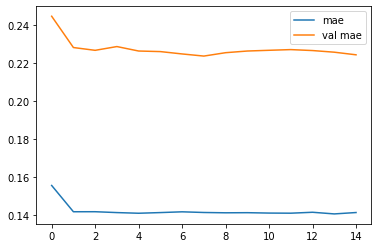

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2253.6226 6.1283154 2587.6168572646143


,actual,prediction
0,38200,33733.933594
1,37850,33788.261719
2,37400,33765.027344
3,37300,33824.117188
4,37150,33804.218750
...,...,...
229,35650,34172.750000
230,36250,34172.171875
231,37500,34163.039062
232,39050,34159.949219


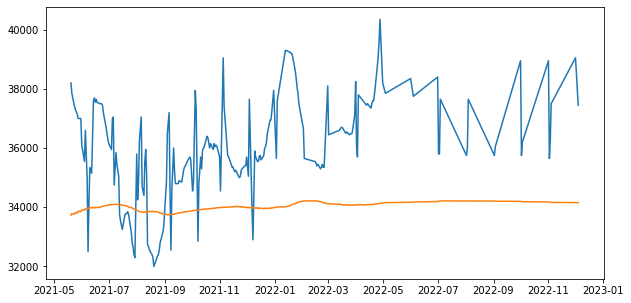

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_ayam_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_ayam1_a1 = pd.DataFrame()
data_new_ayam1_a1['actual'] = x_test
data_new_ayam1_a1['prediction'] = data_result1_a1
data_new_ayam1_a1.to_csv('dagingayam_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_ayam1_a1.actual)
plt.plot(y_test, data_new_ayam1_a1.prediction)
data_new_ayam1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0312 - mae: 0.1365 - mape: 940358.5625 - val_loss: 0.0753 - val_mae: 0.2277 - val_mape: 36.4634
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0312 - mae: 0.1364 - mape: 932116.3125 - val_loss: 0.0760 - val_mae: 0.2289 - val_mape: 36.6046
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0312 - mae: 0.1363 - mape: 931357.9375 - val_loss: 0.0767 - val_mae: 0.2303 - val_mape: 36.7592
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0311 - mae: 0.1363 - mape: 925138.9375 - val_loss: 0.0770 - val_mae: 0.2309 - val_mape: 36.8318
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0311 - mae: 0.1363 - mape: 925803.4375 - val_loss: 0.0774 - val_mae: 0.2316 - val_mape: 36.9143
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0311 - mae: 0.1363 - mape: 923336.8125 - val_loss: 0.0778 - val_mae: 0

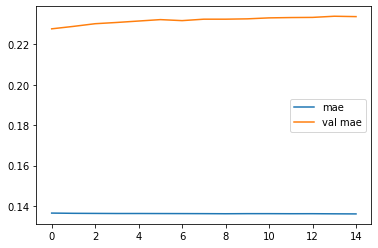

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2384.7834 6.482213 2725.2662255273335


,actual,prediction
0,38200,33561.921875
1,37850,33616.320312
2,37400,33593.074219
3,37300,33652.425781
4,37150,33632.480469
...,...,...
229,35650,33992.933594
230,36250,33992.273438
231,37500,33983.105469
232,39050,33980.058594


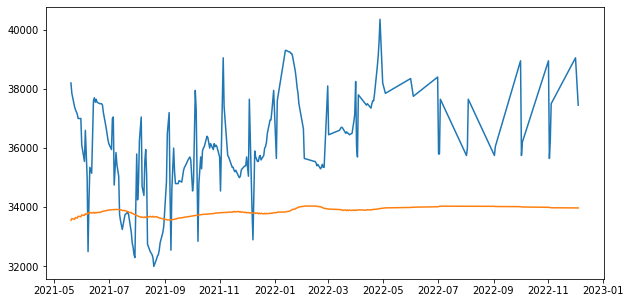

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_ayam_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_ayam1_a2 = pd.DataFrame()
data_new_ayam1_a2['actual'] = x_test
data_new_ayam1_a2['prediction'] = data_result1_a2
data_new_ayam1_a2.to_csv('dagingayam_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_ayam1_a2.actual)
plt.plot(y_test, data_new_ayam1_a2.prediction)

data_new_ayam1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 34ms/step - loss: 0.1816 - mae: 0.3736 - val_loss: 0.4113 - val_mae: 0.6106
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1816 - mae: 0.3734 - val_loss: 0.4112 - val_mae: 0.6105
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1815 - mae: 0.3734 - val_loss: 0.4111 - val_mae: 0.6104
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1814 - mae: 0.3732 - val_loss: 0.4110 - val_mae: 0.6104
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1815 - mae: 0.3734 - val_loss: 0.4109 - val_mae: 0.6103
Epoch 6/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1814 - mae: 0.3733 - val_loss: 0.4108 - val_mae: 0.6102
Epoch 7/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1814 - mae: 0.3730 - val_loss: 0.4108 - val_mae: 0.6101
Epoch 8/100
44/44 [==============================] - 1s 14ms/step - loss: 0.

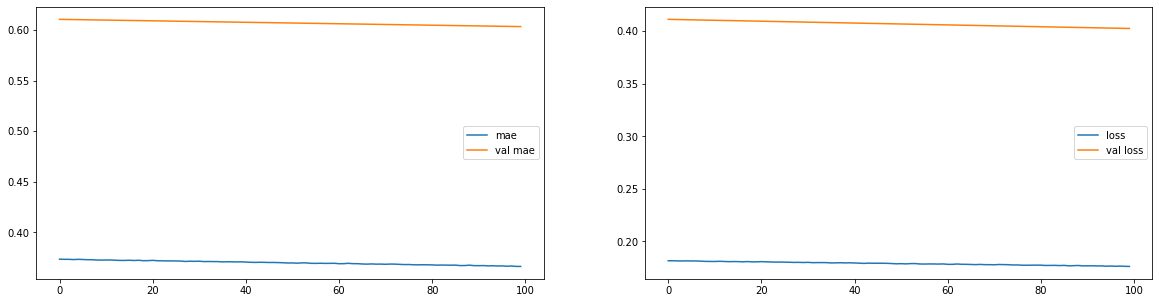

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
7440.0215 20.489986 7628.725450558566


,actual,prediction
0,38200,28527.140625
1,37850,28527.587891
2,37400,28541.822266
3,37300,28523.892578
4,37150,28531.511719
...,...,...
229,35650,28587.177734
230,36250,28587.474609
231,37500,28589.277344
232,39050,28583.894531


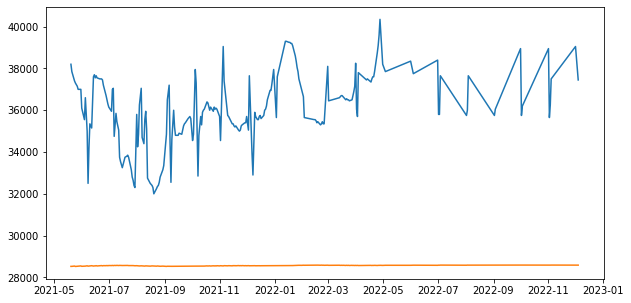

In [58]:
prediction2 = forecast_predict(model2, test_ayam_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_ayam2 = pd.DataFrame()
data_new_ayam2['actual'] = x_test
data_new_ayam2['prediction'] = data_result2
data_new_ayam2.to_csv('dagingayam_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_ayam2.actual)
plt.plot(y_test, data_new_ayam2.prediction)
data_new_ayam2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2189 - mae: 0.4295 - val_loss: 0.4010 - val_mae: 0.6020
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2177 - mae: 0.4281 - val_loss: 0.3993 - val_mae: 0.6007
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2165 - mae: 0.4267 - val_loss: 0.3977 - val_mae: 0.5993
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2154 - mae: 0.4254 - val_loss: 0.3960 - val_mae: 0.5979
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2141 - mae: 0.4240 - val_loss: 0.3944 - val_mae: 0.5966
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2132 - mae: 0.4229 - val_loss: 0.3928 - val_mae: 0.5952
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.2119 - mae: 0.4213 - val_loss: 0.3912 - val_mae: 0.5939
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

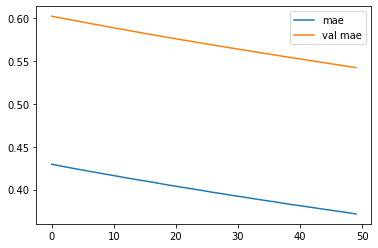

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_ayam_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_ayam2_1 = pd.DataFrame()
data_new_ayam2_1['actual'] = x_test
data_new_ayam2_1['prediction'] = data_result2_1
data_new_ayam2_1.to_csv('dagingayam_model3_sgd_type2.csv')

data_new_ayam2

199/199 [==============================] - 1s 3ms/step
6647.9507 18.28504 6858.048118816315


,actual,prediction
0,38200,28527.140625
1,37850,28527.587891
2,37400,28541.822266
3,37300,28523.892578
4,37150,28531.511719
...,...,...
229,35650,28587.177734
230,36250,28587.474609
231,37500,28589.277344
232,39050,28583.894531


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1399 - mae: 0.3319 - val_loss: 0.3323 - val_mae: 0.5421
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1399 - mae: 0.3318 - val_loss: 0.3322 - val_mae: 0.5419
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1397 - mae: 0.3316 - val_loss: 0.3321 - val_mae: 0.5418
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1398 - mae: 0.3318 - val_loss: 0.3320 - val_mae: 0.5417
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1395 - mae: 0.3313 - val_loss: 0.3318 - val_mae: 0.5416
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1395 - mae: 0.3314 - val_loss: 0.3317 - val_mae: 0.5415
Epoch 7/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1393 - mae: 0.3311 - val_loss: 0.3316 - val_mae: 0.5414
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1394 - m

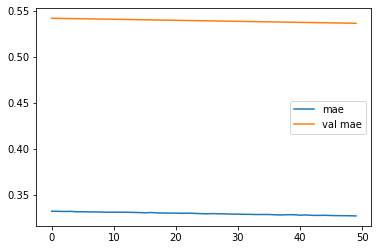

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_ayam_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_ayam2_2 = pd.DataFrame()
data_new_ayam2_2['actual'] = x_test
data_new_ayam2_2['prediction'] = data_result2_2
data_new_ayam2_2.to_csv('dagingayam_model3_sgd_type3.csv')

data_new_ayam2_2

181/181 [==============================] - 1s 4ms/step
6563.7764 18.050789 6776.304892786333


,actual,prediction
0,38200,29397.718750
1,37850,29385.332031
2,37400,29394.703125
3,37300,29393.113281
4,37150,29408.412109
...,...,...
229,35650,29474.185547
230,36250,29466.525391
231,37500,29467.099609
232,39050,29472.187500


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.1312 - mae: 0.3015 - val_loss: 0.2061 - val_mae: 0.4117
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0490 - mae: 0.1758 - val_loss: 0.1289 - val_mae: 0.3149
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0441 - mae: 0.1632 - val_loss: 0.1126 - val_mae: 0.2909
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0447 - mae: 0.1652 - val_loss: 0.1268 - val_mae: 0.3118
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0436 - mae: 0.1629 - val_loss: 0.1181 - val_mae: 0.2987
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0445 - mae: 0.1630 - val_loss: 0.1311 - val_mae: 0.3182
Epoch 7/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0439 - mae: 0.1633 - val_loss: 0.1222 - val_mae: 0.3048
Epoch 8/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0441 - m

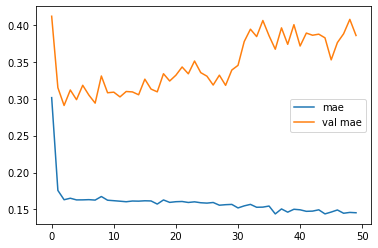

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_ayam_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_ayam2_a = pd.DataFrame()
data_new_ayam2_a['actual'] = x_test
data_new_ayam2_a['prediction'] = data_result2_a
data_new_ayam2_a.to_csv('dagingayam_model3_adam_type1.csv')

data_new_ayam2_a

131/131 [==============================] - 1s 6ms/step
2765.2266 7.5108395 3167.269486482008


,actual,prediction
0,38200,34069.269531
1,37850,34250.027344
2,37400,34469.593750
3,37300,34557.640625
4,37150,34340.523438
...,...,...
229,35650,33190.601562
230,36250,33216.675781
231,37500,33191.757812
232,39050,33173.597656


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0320 - mae: 0.1401 - val_loss: 0.1097 - val_mae: 0.2867
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0307 - mae: 0.1351 - val_loss: 0.0760 - val_mae: 0.2290
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0291 - mae: 0.1319 - val_loss: 0.0917 - val_mae: 0.2582
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0302 - mae: 0.1348 - val_loss: 0.0873 - val_mae: 0.2492
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0301 - mae: 0.1332 - val_loss: 0.0858 - val_mae: 0.2465
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0298 - mae: 0.1325 - val_loss: 0.0916 - val_mae: 0.2577
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0294 - mae: 0.1306 - val_loss: 0.0938 - val_mae: 0.2603
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

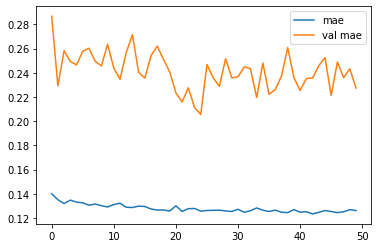

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
2043.8472 5.551363 2509.2556665274265


,actual,prediction
0,38200,33645.695312
1,37850,33849.761719
2,37400,34157.105469
3,37300,34038.183594
4,37150,33962.117188
...,...,...
229,35650,35612.601562
230,36250,35603.871094
231,37500,35634.742188
232,39050,35619.140625


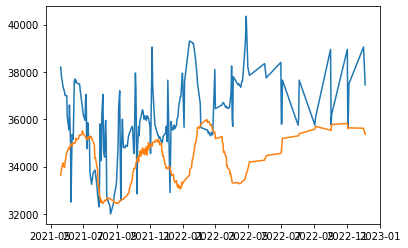

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_ayam_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_ayam2_a1 = pd.DataFrame()
data_new_ayam2_a1['actual'] = x_test
data_new_ayam2_a1['prediction'] = data_result2_a1
data_new_ayam2_a1.to_csv('dagingayam_model3_adam_type2.csv')

plt.plot(y_test, data_new_ayam2_a1.actual)
plt.plot(y_test, data_new_ayam2_a1.prediction)
data_new_ayam2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0265 - mae: 0.1206 - val_loss: 0.0768 - val_mae: 0.2294
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0264 - mae: 0.1195 - val_loss: 0.0752 - val_mae: 0.2271
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0265 - mae: 0.1214 - val_loss: 0.0765 - val_mae: 0.2304
Epoch 4/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0262 - mae: 0.1199 - val_loss: 0.0761 - val_mae: 0.2294
Epoch 5/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0262 - mae: 0.1204 - val_loss: 0.0756 - val_mae: 0.2284
Epoch 6/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0259 - mae: 0.1189 - val_loss: 0.0763 - val_mae: 0.2300
Epoch 7/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0259 - mae: 0.1185 - val_loss: 0.0769 - val_mae: 0.2312
Epoch 8/100
84/84 [==============================] - 1s 11ms/step - loss: 0.

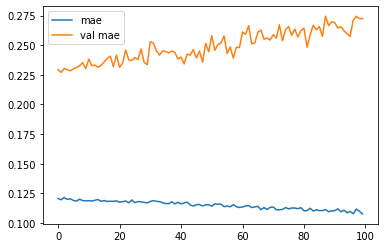

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 4ms/step
2821.0037 7.66774 3228.9454935009353


,actual,prediction
0,38200,33819.222656
1,37850,34223.234375
2,37400,34038.843750
3,37300,34520.933594
4,37150,34356.144531
...,...,...
229,35650,33131.683594
230,36250,33160.714844
231,37500,33173.027344
232,39050,33247.648438


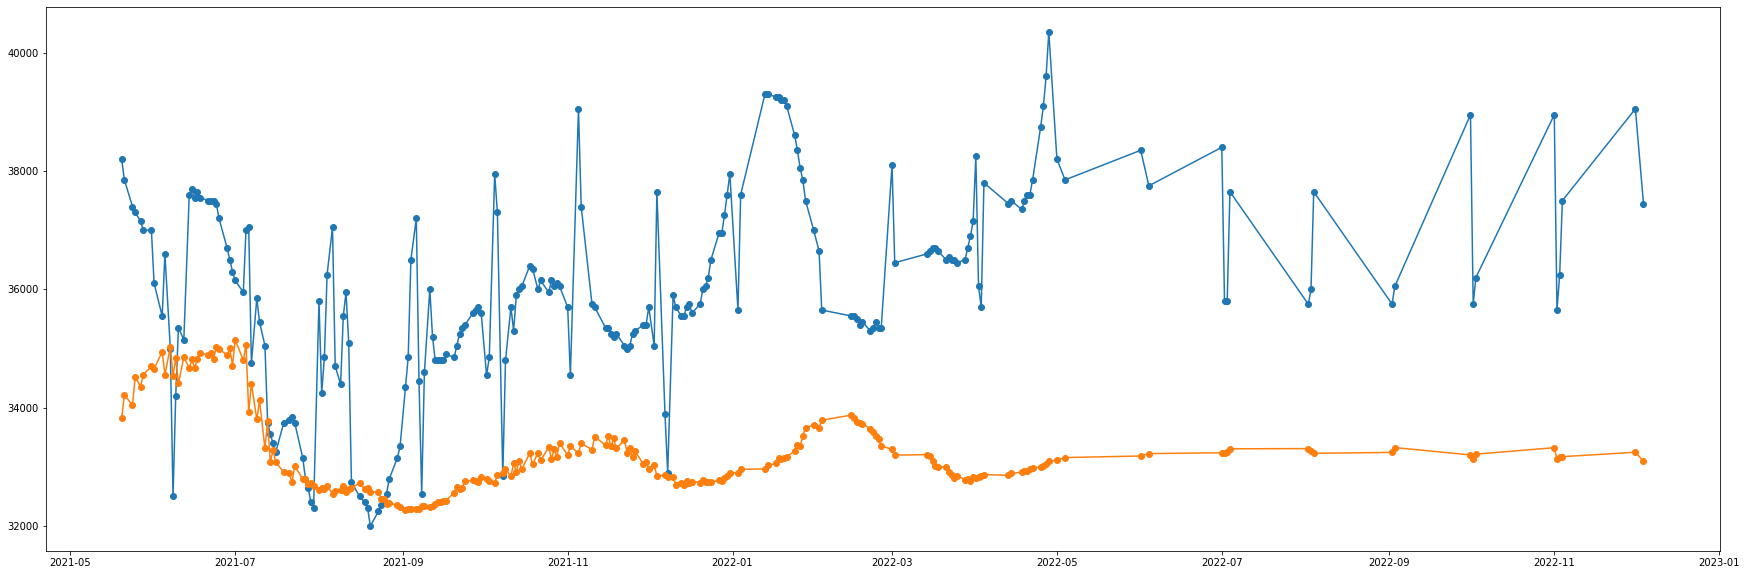

In [75]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_ayam_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_ayam2_a2 = pd.DataFrame()
data_new_ayam2_a2['actual'] = x_test
data_new_ayam2_a2['prediction'] = data_result2_a2
data_new_ayam2_a2.to_csv('dagingayam_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_ayam2_a2.actual, '-o')
plt.plot(y_test,data_new_ayam2_a2.prediction, '-o')
data_new_ayam2_a2